# Manual Network finding

This notebook will work finding the best trade-off for our own implemented neural network, using previous data transformation

**Main goals are**: 
- Compare different implementations of neural network
- Understand how a simple neural network works
- Look at the performance and results of PCA's transformed and manually transformed one
- Expose results that will be compared to ML ones


**First we retreive our data and preprocess it :**

In [1]:
from local_lib.dataset import retreiveDatasetFromCsv
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from local_lib.flatten_transformer import FlattenTransformer
from local_lib.dimension_transformer import DimensionTransformer
import numpy as np
from sklearn.decomposition import PCA

dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

pipeline = Pipeline([
    ('flatten_tr', FlattenTransformer()),
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('dimension_tr', DimensionTransformer())])

**We also prepare a version of input data that include PCA transformation**

In [4]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=0)

In [8]:
print(X_train.shape)
print(X_train_pca.shape)

(3923, 26302)
(3923, 50)


_We may expect longer computation time when using manually transformed data_

**Need to transpose input and output layers because we used transposed version of LogLoss for more explicit visualization**

In [9]:
import numpy as np
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
X_train = X_train.T
X_test = X_test.T

y_train_pca = y_train_pca.reshape(1, -1)
y_test_pca = y_test_pca.reshape(1, -1)
X_train_pca = X_train_pca.T
X_test_pca = X_test_pca.T

In [10]:
print('-----manually transformed')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print('-----pca transformed')
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train_pca.shape)
print(y_test_pca.shape)

-----manually transformed
(26302, 3923)
(26302, 1933)
(1, 3923)
(1, 1933)
-----pca transformed
(50, 3923)
(50, 1933)
(1, 3923)
(1, 1933)


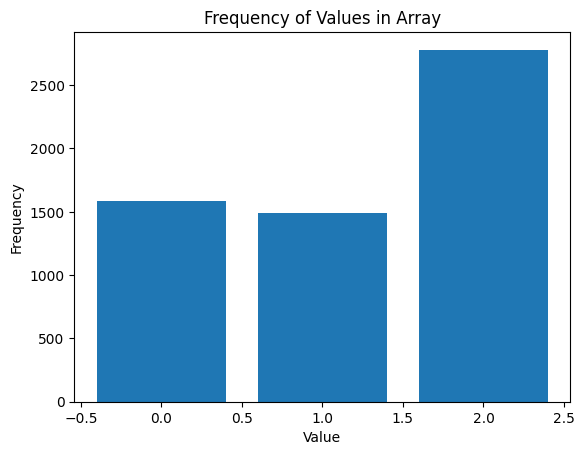

In [143]:
from collections import Counter
import matplotlib.pyplot as plt


counter = Counter(y)

# Convert Counter to dictionary
grouped = dict(counter)

# Extract keys and values
keys = list(grouped.keys())
values = list(grouped.values())

# Plot the bar chart
plt.bar(keys, values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Array')
plt.show()


**Very important :** We scale our data to avoid exponential overflow

In [11]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('minmax', MinMaxScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)
X_train_pca = pipeline.fit_transform(X_train_pca)
X_test_pca = pipeline.fit_transform(X_test_pca)

**Very important :** We transform output data to have a shape of (1, 3) so our model can make a prediction on each class and not rescale it between [0,1]

In [16]:
import numpy as np

# Tableau initial
t1 = np.array([0, 0, 0, 1, 2, 1, 1, 2, 2])

# Création de la matrice identité
identity_matrix = np.eye(3)

# Transformation de t1 en t2
y_train_reshaped = identity_matrix[y_train[0]].T
y_test_reshaped = identity_matrix[y_test[0]].T

y_train_reshaped_pca = identity_matrix[y_train_pca[0]].T
y_test_reshaped_pca = identity_matrix[y_test_pca[0]].T

print(y_train_reshaped.shape)
print(y_train_reshaped_pca.shape)

(3, 3923)
(3, 3923)


**Instantiate a sample neural network (no output reshape)**

In [82]:
from local_lib.multiclass_neural_network import MultiClassNeuralNetwork
mnn = MultiClassNeuralNetwork(X_train, y_train, dimensions=(8,8,8), n_iter=500, lr=0.05)
hist = mnn.fit(X_train, X_test, y_train,y_test)

{0: 0.16, 1: 0.5, 2: 0.84}
[[0.0, 0.33, 0], [0.33, 0.67, 1], [0.67, 1.0, 2]]


100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


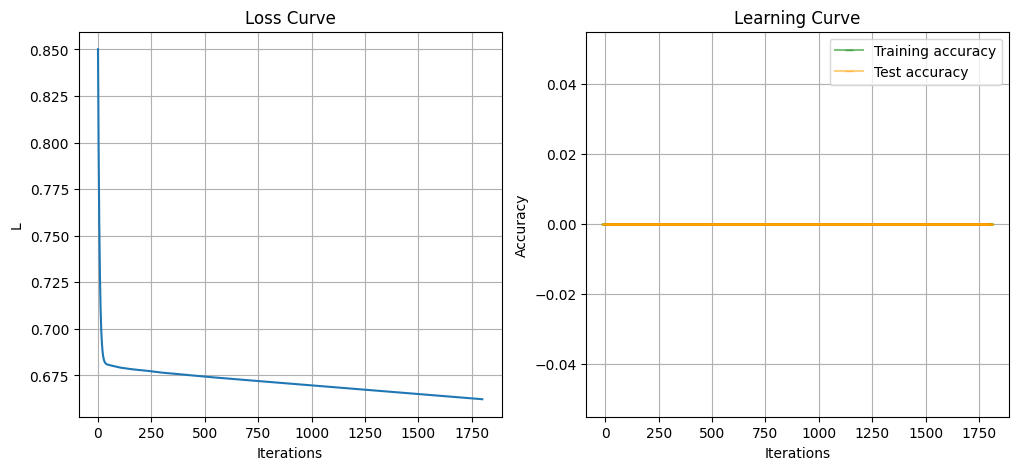

In [76]:
#(8,8,8) [0,1]
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#region Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 0])
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('L')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), marker='_', label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), marker='_', label='Test accuracy')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
#endregion

In [101]:
y_pred = mnn.predict(X_test)
print("All differents labels predicted by our mnn :")
np.unique(y_pred)

All differents labels predicted by our mnn :


array([1])

**Huge problems on accuracy due to impact of implementation**<br>
Classes are converted into a range between 0 and 1 but each prediction impact other, even if it's not same classe

In [102]:
from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train, y_train_reshaped, dimensions=(8,8,8), n_iter=1800, lr=0.05)
hist = mnn.fit(X_train, X_test, y_train_reshaped,y_test_reshaped)

100%|██████████| 1800/1800 [09:52<00:00,  3.04it/s]


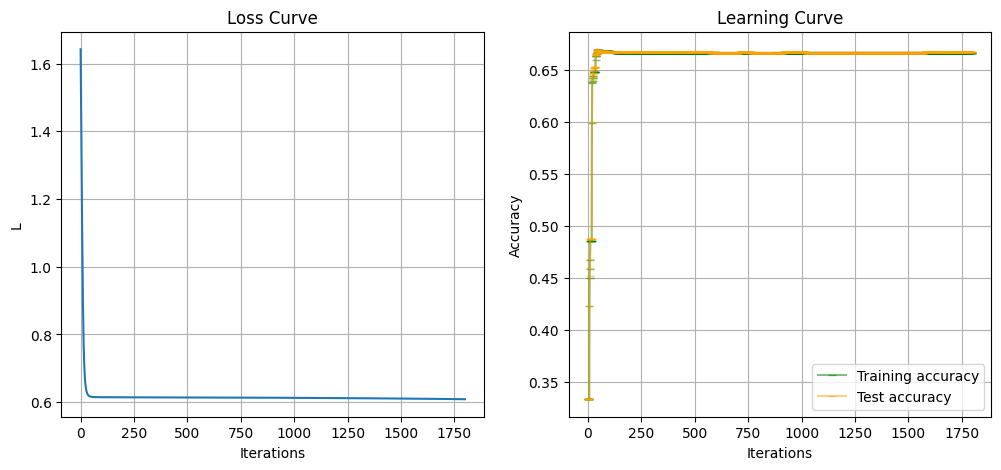

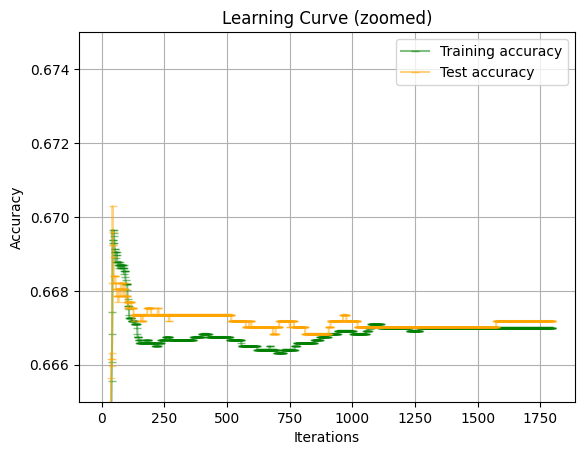

In [111]:
#(8,8,8)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#region Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 0])
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('L')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), label='Test accuracy')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


ax = plt.subplot(1, 1, 1)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), label='Test accuracy')
ax.set_ylim((0.665, 0.675))
plt.title('Learning Curve (zoomed)')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
#endregion

Confusion matrix:
[[517   0   1]
 [489   0   0]
 [922   0   4]]


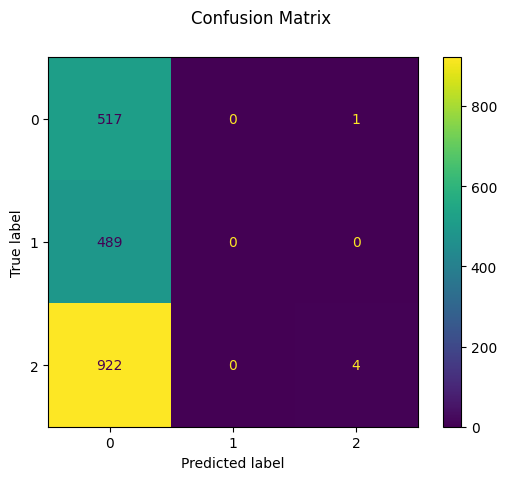

In [138]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = mnn.predict(X_test)
y_test_reshaped.shape

disp = ConfusionMatrixDisplay.from_predictions(y_test[0,:], np.argmax(y_pred, axis=0))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

**Corrected prediction format, still, computation time is really high and results are terrible**<br>
Switching to PCA processed data

In [139]:
from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train_pca, y_train_reshaped_pca, dimensions=(8,8,8), n_iter=1800, lr=0.05)
hist = mnn.fit(X_train_pca, X_test_pca, y_train_reshaped_pca,y_test_reshaped_pca)

100%|██████████| 1800/1800 [00:17<00:00, 104.02it/s]


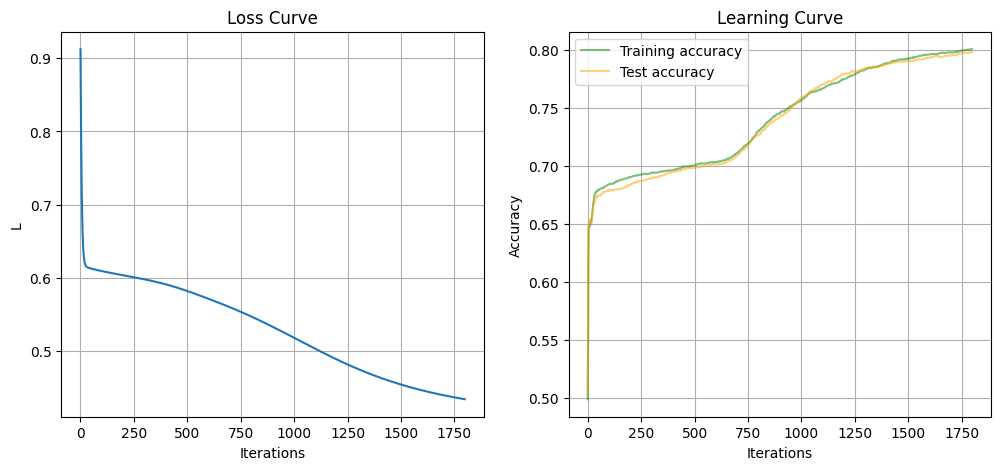

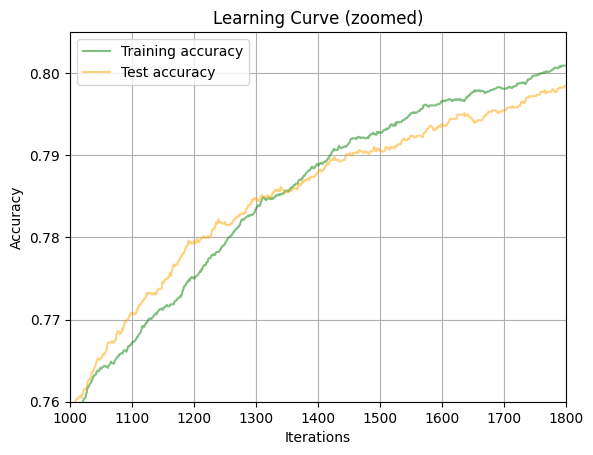

In [148]:
#(8,8,8)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#region plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 0])
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('L')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5),  label='Test accuracy')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


ax = plt.subplot(1, 1, 1)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), label='Test accuracy')
ax.set_ylim((0.76, 0.805))
ax.set_xlim((1000, 1800))
plt.title('Learning Curve (zoomed)')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
#endregion

Confusion matrix:
[[489   0  29]
 [156   0 333]
 [145   0 781]]


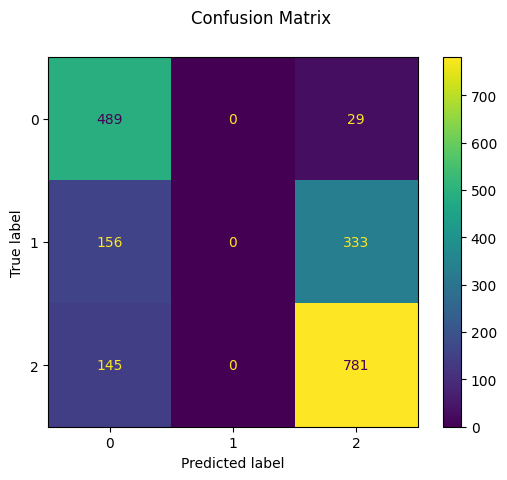

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = mnn.predict(X_test_pca)
y_test_reshaped.shape

disp = ConfusionMatrixDisplay.from_predictions(y_test[0,:], np.argmax(y_pred, axis=0))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

**Computation time is better** and we could apparently go a bit further in term of **iterations**<br>
Also, PCA seems to add a good first **abstraction that prevent overfit** <br>
_Now we will start to work on generalisation by implementing batching_

**Sequential Batching**

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_score
from tqdm import tqdm
import math

class NeuralNetworkMultiLayerSequentialStrat():
    def __init__(self, X, y, dimensions = (16, 16, 16), lr=0.1, n_iter=1000, test_size=0.2, strategy="full", sub_parts=5):
        self.lr = lr
        self.n_iter = n_iter
        self.test_size = test_size
        self.dimensions = list(dimensions)
        self.dimensions.insert(0, X.shape[0])
        self.dimensions.append(y.shape[0])
        self.parameters = {}
        self.strategy = strategy
        self.sub_parts = sub_parts

        # Initialisation de W1, b1, ...
        C = len(self.dimensions)
        for c in range(1, C):
            self.parameters['W' + str(c)] = np.random.randn(self.dimensions[c], self.dimensions[c - 1])
            self.parameters['b' + str(c)] = np.random.randn(self.dimensions[c], 1)


    def forward_propagation(self, X):
        activations = {'A0': X}

        C = len(self.parameters) // 2

        for c in range(1, C + 1):
            if(not np.any(activations['A' + str(c - 1)])):
                print("Nan in activations")
                raise ValueError("Nan found")
            Z = self.parameters['W' + str(c)].dot(activations['A' + str(c - 1)]) + self.parameters['b' + str(c)]
            activations['A' + str(c)] = 1 / (1 + np.exp(-Z))

        return activations
    
    def back_propagation(self, y, activations):

        m = y.shape[1]
        C = len(self.parameters) // 2
        dZ = activations['A' + str(C)] - y
        gradients = {}

        for c in reversed(range(1, C + 1)):
            gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c - 1)].T)
            gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
            #N'a pas de sens pour Z0
            if c > 1:
                dZ = np.dot(self.parameters['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])

        return gradients

    def update(self, gradients):

        C = len(self.parameters) // 2

        for c in range(1, C + 1):

            self.parameters['W' + str(c)] = self.parameters['W' + str(c)] - self.lr * gradients['dW' + str(c)]
            self.parameters['b' + str(c)] = self.parameters['b' + str(c)] - self.lr * gradients['db' + str(c)]

        return

    def predict(self, X):
        activations = self.forward_propagation(X)
        C = len(self.parameters) // 2
        Af = activations['A' + str(C)]
        return Af >= 0.5
    
    def fit(self, X_train, X_test, y_train, y_test):

        training_history = np.zeros((int(self.n_iter) + 1, 3))

        C = len(self.parameters) // 2

        # gradient descent
        if(self.strategy == "full"):
            for i in tqdm(range(self.n_iter)):
                activations = self.forward_propagation(X_train)
                gradients = self.back_propagation(y_train, activations)
                self.update(gradients)
                Af = activations['A' + str(C)]
                # calcul du log_loss et de l'accuracy
                training_history[i, 0] = (log_loss(y_train.flatten(), Af.flatten()))
                y_pred_train = self.predict(X_train)
                y_pred_test = self.predict(X_test)
                training_history[i, 1] = (accuracy_score(y_train.flatten(), y_pred_train.flatten()))
                training_history[i, 2] = (accuracy_score(y_test.flatten(), y_pred_test.flatten()))

        elif(self.strategy == "sub"):
            
            self.n_iter = (np.floor(self.n_iter / self.sub_parts)).astype(int)
            portion = 1 / self.sub_parts

            nb_element_sub_train = math.floor(X_train.shape[1] * portion)
            nb_element_sub_test = math.floor(X_test.shape[1] * portion)
            e = 0
            for x in range(0, self.sub_parts):
                start_train_index = nb_element_sub_train * x
                end_train_index = nb_element_sub_train * (x+1)
                start_test_index = nb_element_sub_test * x
                end_test_index = nb_element_sub_test * (x+1)
                X_train_sub = X_train[:, start_train_index:end_train_index]
                X_test_sub = X_test[:, start_test_index:end_test_index]
                y_train_sub = y_train[:, start_train_index:end_train_index]
                y_test_sub = y_test[:, start_test_index:end_test_index]
                print(X_train_sub.shape)
                print(X_test_sub.shape)
                
                for i in tqdm(range(self.n_iter)):
                    e+=1
                    activations = self.forward_propagation(X_train_sub)
                    gradients = self.back_propagation(y_train_sub, activations)
                    self.update(gradients)
                    Af = activations['A' + str(C)]
                    # calcul du log_loss et de l'accuracy
                    training_history[e, 0] = log_loss(y_train_sub.flatten(), Af.flatten())
                    y_pred_train = self.predict(X_train_sub)
                    y_pred_test = self.predict(X_test_sub)
                    training_history[e, 1] = accuracy_score(y_train_sub.flatten(), y_pred_train.flatten())
                    training_history[e, 2] = accuracy_score(y_test_sub.flatten(), y_pred_test.flatten())

        else:
            raise ValueError("Unsupported strategy")
        return training_history

In [170]:
# from local_lib.neural_network_sequential_batch import NeuralNetworkMultiLayerSequentialStrat
mnn = NeuralNetworkMultiLayerSequentialStrat(X_train_pca, y_train_reshaped_pca, dimensions=(8,8,8), n_iter=1800, lr=0.5, strategy="sub", sub_parts=8)
hist = mnn.fit(X_train_pca, X_test_pca, y_train_reshaped_pca,y_test_reshaped_pca)

(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 549.74it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 484.13it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 507.12it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 556.01it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 524.14it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 540.46it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 512.57it/s]


(50, 490)
(50, 241)


100%|██████████| 225/225 [00:00<00:00, 531.90it/s]


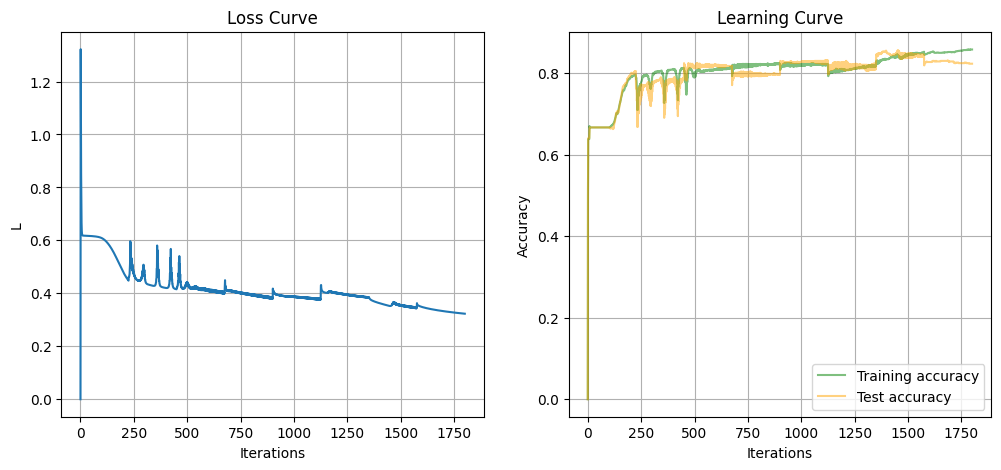

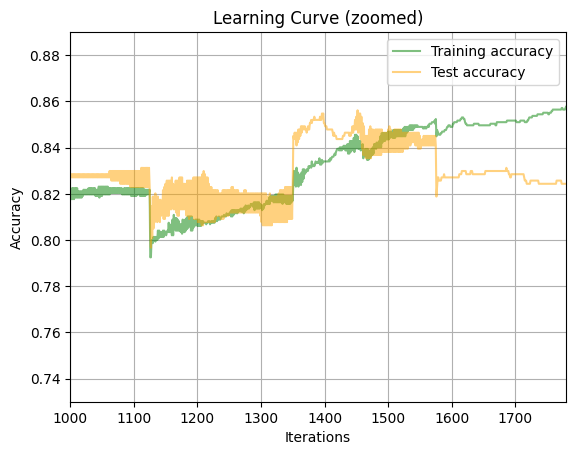

In [174]:
#(8,8,8)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#region plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 0])
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('L')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5),  label='Test accuracy')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


ax = plt.subplot(1, 1, 1)
plt.plot(range(hist[:, 1].shape[0]), hist[:, 1], color=('green', 0.5), label='Training accuracy')
plt.plot(range(hist[:, 2].shape[0]), hist[:, 2], color=('orange', 0.5), label='Test accuracy')
ax.set_ylim((0.73, 0.89))
ax.set_xlim((1000, 1780))
plt.title('Learning Curve (zoomed)')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
#endregion

Confusion matrix:
[[478  27  13]
 [ 74 182 233]
 [ 81  89 756]]


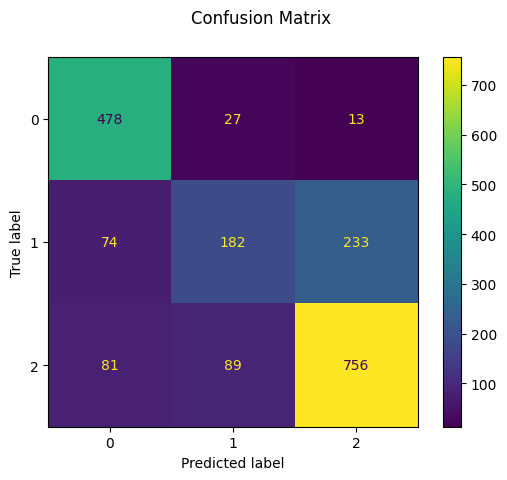

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = mnn.predict(X_test_pca)
y_test_reshaped.shape

disp = ConfusionMatrixDisplay.from_predictions(y_test[0,:], np.argmax(y_pred, axis=0))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

**May not be the most optimized learning method due to individual overfit on each batch**<br>
Now we will try to implement concurrent batching to avoid overfitting

**Concurrent batching**

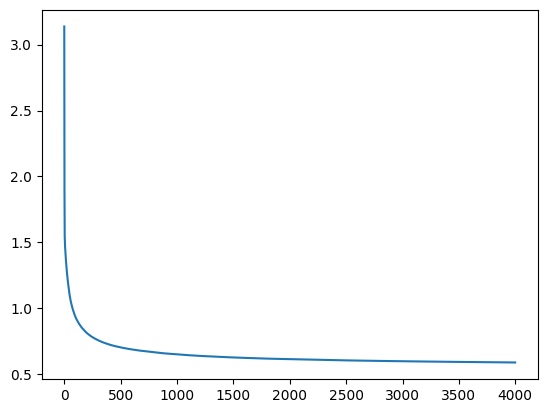

In [41]:
#(128,128,128,128)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

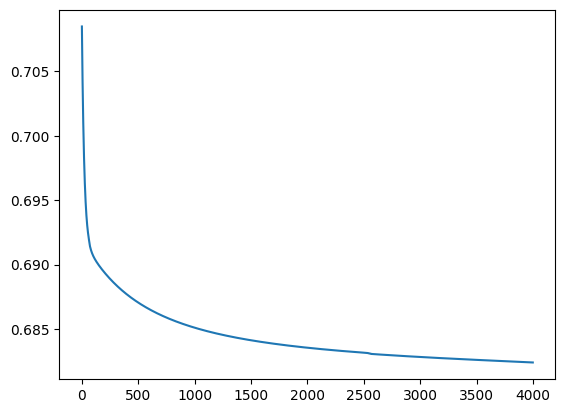

In [30]:
#(2,2)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

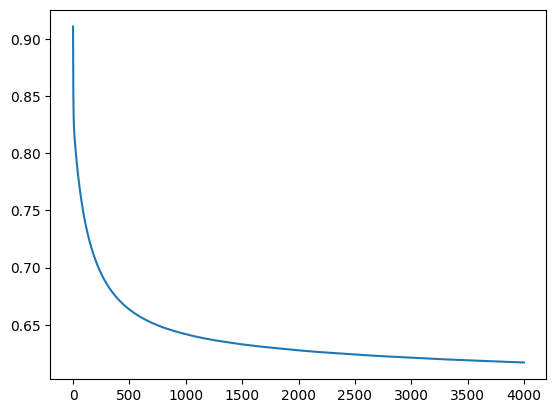

In [35]:
#(16,16,16)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

In [48]:
X_train[:,:].max()

1.0000000000000002

In [53]:
mnn = MultiClassNeuralNetwork(X_train, y_train, dimensions=(256,256,256,256), n_iter=4000, lr=0.05)
hist = mnn.fit(X_train, X_test, y_train,y_test)

{0: 0.16, 1: 0.5, 2: 0.84}
[[0.0, 0.33, 0], [0.33, 0.67, 1], [0.67, 1.0, 2]]


100%|██████████| 4000/4000 [18:17<00:00,  3.65it/s]


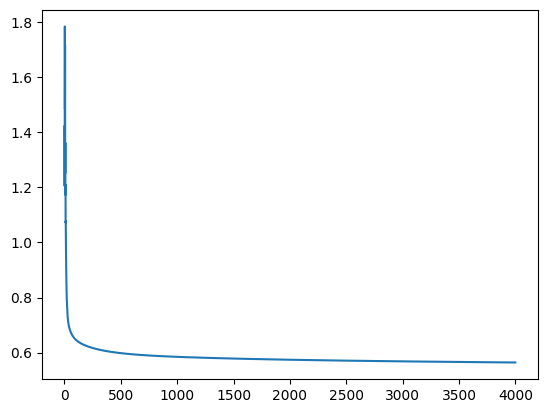

In [54]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

In [55]:
hist[:, 0].min()

0.5642384312612551

In [10]:
y_train_reshaped.shape

(3, 3923)

In [13]:
from local_lib.neural_network_multi_layer import NeuralNetworkMultiLayer

mnn = NeuralNetworkMultiLayer(X_train, y_train_reshaped, dimensions=(64,64,64), n_iter=4000, lr=0.05)
mnn.dimensions
hist = mnn.fit(X_train, X_test,y_train_reshaped, y_test_reshaped)

100%|██████████| 4000/4000 [03:30<00:00, 18.97it/s]


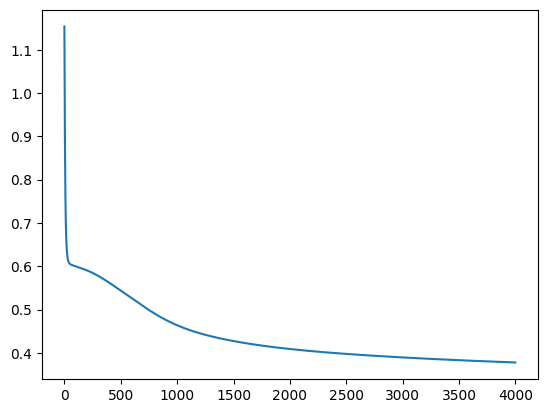

In [12]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[:, 0])
plt.show()

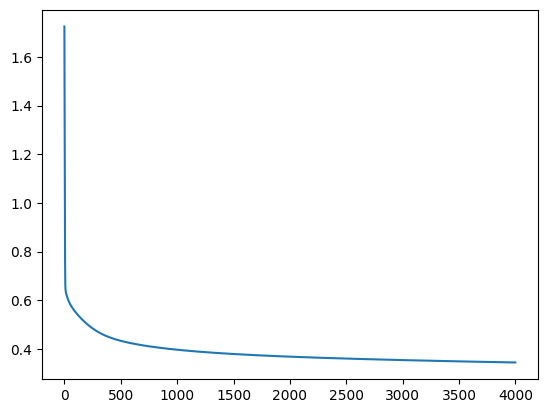

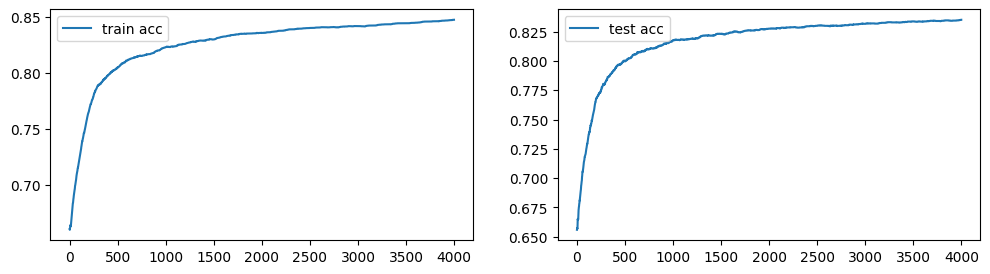

In [16]:
#(64,64,64)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.subplot(1, 2, 0)
plt.plot(hist[:, 0])
plt.show()
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 1], label='train acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist[:, 2], label='test acc')
plt.legend()
plt.show()

In [49]:
X_test.shape

(50, 1933)

In [16]:
X_train[:, 784:1569].min()

0.0

In [144]:
mnn = NeuralNetworkMultiLayerStrat(X_train, y_train_reshaped, dimensions=(32,32,32), n_iter=4000, lr=0.1, strategy="sub")
hist = mnn.fit(X_train, X_test,y_train_reshaped, y_test_reshaped)

100%|██████████| 799/799 [00:31<00:00, 25.77it/s]


In [133]:
hist[3935,0]

0.5572859361091179

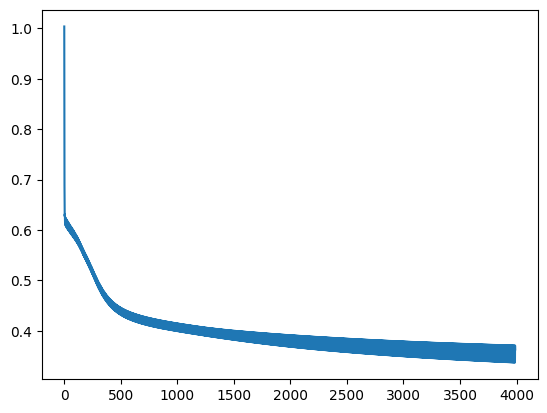

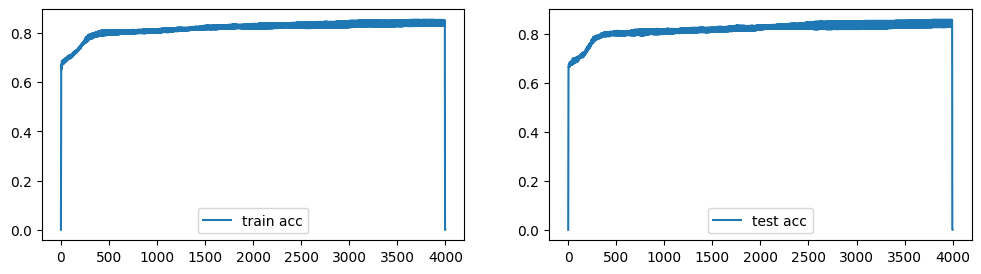

In [148]:
#(64,64,64)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

plt.plot(hist[1:3990, 0])
plt.show()
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(hist[:, 1], label='train acc')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist[:, 2], label='test acc')
plt.legend()
plt.show()